<a href="https://colab.research.google.com/github/amrios80/GroceryStoreDataset/blob/master/code/taller2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TALLER 2

## Objetivo
Aplicar técnicas de machine learning, las cuales permitan descubrir insights, sugerir accionables al negocio y calcular el valor ganado.

## Contexto del negocio: Apoyo a un Supermercado Inteligente

El concepto de supermercado inteligente está transformando la manera en que interactuamos con los entornos de retail, combinando la inteligencia artificial, la automatización y la ciencia de datos para ofrecer una experiencia de compra más eficiente, personalizada y sin fricciones. Estos supermercados están diseñados para mejorar todos los aspectos del proceso de compra, desde la entrada del cliente hasta la salida, utilizando tecnologías avanzadas para automatizar tareas, gestionar inventarios en tiempo real y analizar el comportamiento del consumidor.

Usted ha sido contratado como científico de datos para un nuevo supermercado inteligente, que ya ha implementado tecnologías avanzadas como sensores, cámaras y para iniciar la automatización de procesos, ahora necesita aprovechar mejor los datos generados a diario para tomar decisiones más informadas y eficaces.

El supermercado le ha dado la responsabilidad de desarrollar integrado un sistema de automatización que permite a los clientes tomar productos y salir sin pasar por caja, mientras las cámaras y sensores registran automáticamente los artículos seleccionados.

Para esto le ha proporcionado un dataset abierto de varios productos de mercado que además tiene etiquetas suficientes para identificar el tipo de productos: [GroceryStoreDataset](https://github.com/marcusklasson/GroceryStoreDataset)


## Misión
Mediante el uso de modelos de Machine Learning, en conjunto con técnicas de preparación de datos, se espera que usted esté en capacidad de construir el modelo que identifique los productos, y argumente el valor que generará al supermercado los resultados que obtenga.

### Indice
- [1. Entendimiento y preparación de los datos](#1.-Entendimiento-y-preparación-de-los-datos)
- [2. Entrenamiento del modelo de machine learning](#2.-Entrenamiento-del-modelo-de-machine-learning)
- [3. Análisis de resultados del modelo](#3.-Analisis-de-resultados-del-modelo)
- [4. Generación de Valor](#4.-Generacion-de-Valor)
- [Bono](#Bono)

## 1. Entendimiento y preparación de los datos

Reporte de entendimiento de datos.

*   Dimensiones del dataset
*   Caracteristicas de las imagenes
*   Indicadores importantes
*   Intergracion de tecnicas de aumento de datos
*   Determinacion de productos y que categorías a emplear


### Cargar librerias

In [9]:
import pandas as pd
import numpy as np
import cv2
import os
import requests
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

import warnings
import sys
import random

In [10]:
# configuración general
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', 200)
pd.set_option('expand_frame_repr', False)
np.set_printoptions(threshold=sys.maxsize)

In [11]:
# Establecer la semilla general
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

### Generacion del dataset con la metadata y la informacion de las imagenes.

In [13]:
# Unifica metadata de train, test y val en un solo dataset
data_dir="./dataset/"

url_train="./dataset/train.txt"
url_test="./dataset/test.txt"
url_val="./dataset/val.txt"
df_train=pd.read_csv(url_train, header=None)
df_train["mode"]="train"
df_test=pd.read_csv(url_test, header=None)
df_test["mode"]="test"
df_val=pd.read_csv(url_val, header=None)
df_val["mode"]="val"

img_file_columns=["filename","class_id", "coarse_class_id", "mode"]
df_train.columns=img_file_columns
df_test.columns=img_file_columns
df_val.columns=img_file_columns

df_combined = pd.concat([df_train, df_test, df_val], axis=0, ignore_index=True)

print("numero de archivos por modo:")
print(df_combined["mode"].value_counts())

numero de archivos por modo:
mode
train    2640
test     2485
val       296
Name: count, dtype: int64


In [14]:
# Función para extraer la categoría (ej. "Fruit") de la ruta de la imagen
def extraer_categoria(path):
    # Dividir la ruta de la imagen en partes
    partes = path.split('/')
    # El segundo elemento (índice 1) es la categoría
    return partes[1] if len(partes) > 1 else None

In [15]:
# Se agrega la categoria a la cual pertenece la imagen
df_combined['category'] = df_combined['filename'].apply(extraer_categoria)

In [16]:
# Funcion que carga una imagen de una url o un directorio en disco
def load_image(data_dir, filepath):
        img_path = os.path.join(data_dir, filepath)
        img=[]
        if "http" in img_path:
          url=img_path
          response = requests.get(url)
          if response.status_code == 200:
            image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            if not img.any():
                print(f"Error loading image: {img_path}")
        else:
            img = cv2.imread(img_path)
        if not img.any():
            return []
        return img

In [17]:
# Agrega la informacion de la imagen (size_x, size_y, size y channels) al dataset inicial (df_combined) mediante la funcion get_metada
def get_metadata(df , data_dir="./dataset/"):
    df["size_x"]=0
    df["size_y"]=0
    df["size"]=0
    df["channels"]=0
    count=0
    for index, row in df.iterrows():
        count=count+1
        filepath=row["filename"]
        img=load_image( data_dir, filepath )
        if img.any():
            size_y, size_x = img.shape[:2]  # Height, Width
            channels = img.shape[2] if len(img.shape) == 3 else 1  # Number of channels
            df.loc[index,"size_x"]=size_x
            df.loc[index,"size_y"]=size_y
            df.loc[index,"channels"]=channels
            df.loc[index,"size"]=size_x*size_y*channels
    print(f'Procesadas {count} imagenes')
    return df

In [18]:
data_dir="./dataset/"
df_metadata=get_metadata( df=df_combined, data_dir=data_dir )

Procesadas 5421 imagenes


In [19]:
# Visualización de datos
df_metadata.head(3)

,filename,class_id,coarse_class_id,mode,category,size_x,size_y,size,channels
0,train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg,0,0,train,Fruit,348,348,363312,3
1,train/Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg,0,0,train,Fruit,348,348,363312,3
2,train/Fruit/Apple/Golden-Delicious/Golden-Delicious_003.jpg,0,0,train,Fruit,348,348,363312,3


In [20]:
# Función para mostrar varias imágenes aleatorias
def mostrar_imagenes_aleatorias(df, n=5):
    # Seleccionar n filas aleatorias
    random_rows = df.sample(n=n)
    
    # Configurar el tamaño de la figura para mostrar múltiples imágenes
    fig, axes = plt.subplots(1, n, figsize=(20, 5))
    
    # Iterar sobre las filas seleccionadas aleatoriamente
    for i, (index, row) in enumerate(random_rows.iterrows()):
        image_path = row['filename']
        
        try:
            # Abrir la imagen usando PIL
            image = Image.open(data_dir+image_path)
            
            # Mostrar la imagen en el eje correspondiente
            axes[i].imshow(image)
            axes[i].axis('off')  # Desactivar los ejes
            axes[i].set_title(f"Class: {row['class_id']},\nCoarse Class: {row['coarse_class_id']} ")
        except Exception as e:
            print(f"Error al cargar la imagen en la fila {index}: {e}")
            axes[i].axis('off')  # Si hay un error, desactivar el eje y no mostrar nada
    
    # Mostrar las imágenes
    plt.show()

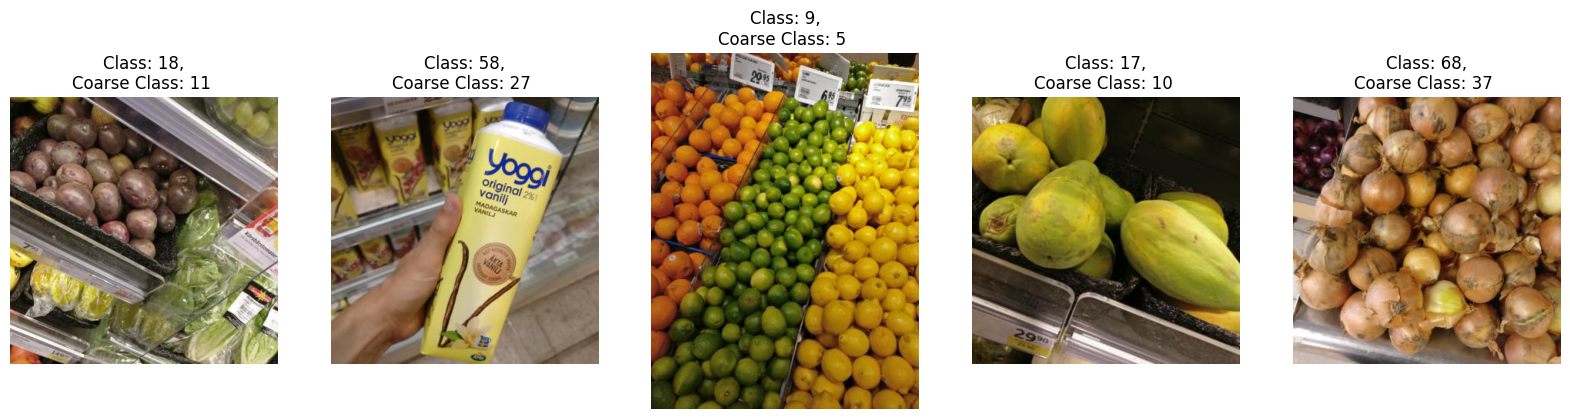

In [21]:
# Llamar a la función para mostrar 5 imágenes aleatorias
mostrar_imagenes_aleatorias(df_combined, n=5)

### Dimensiones del dataset



In [23]:
print("Número de imágenes " + str(df_metadata[df_metadata["filename"].str.contains(".jpg")].shape[0]) )
print("\nArchivos por modo:\n" + str(df_metadata["mode"].value_counts() ))

Número de imágenes 5421

Archivos por modo:
mode
train    2640
test     2485
val       296
Name: count, dtype: int64


### Caracteristicas de las imagenes



In [25]:
df_metadata[["size","size_x","size_y","channels"]].describe()

,size,size_x,size_y,channels
count,5421.000000,5421.000000,5421.000000,5421.0
mean,373655.322634,348.791736,357.115661,3.0
std,33850.329284,9.551510,31.217002,0.0
min,363312.000000,348.000000,348.000000,3.0
25%,363312.000000,348.000000,348.000000,3.0
50%,363312.000000,348.000000,348.000000,3.0
75%,363312.000000,348.000000,348.000000,3.0
max,484416.000000,464.000000,464.000000,3.0


### Indicadores

In [27]:
print("Cantidad de clases        : "+str(df_metadata["class_id"].nunique()))
print("Cantidad de coarse classes: "+str(df_metadata["coarse_class_id"].nunique()))
print("Tamaño en disco           : "+str(df_metadata["size"].sum()/1000000 )+ " MB ")
print("numero de archivos        : "+str(df_metadata.shape[0]))
print("Tamaño promedio           : "+str(df_metadata["size"].mean()/1000 )+ " KB")
print("Categorias                : "+str(df_metadata["category"].nunique())+" (Fruit, Packages, Vegetables)")

Cantidad de clases        : 81
Cantidad de coarse classes: 43
Tamaño en disco           : 2025.585504 MB 
numero de archivos        : 5421
Tamaño promedio           : 373.65532263420033 KB
Categorias                : 3 (Fruit, Packages, Vegetables)


### Determinacion de productos y que categorías a emplear
Se utilizaran todos los productos y sus categorias con el objetivo de cubrir completamente el inventario existente en la tienda.

### Creación de los conjuntos X, y para train, test y val

In [30]:
def loop_file(filename, mode="train", data_dir="./dataset/", image_x=128 , image_y=128):
    images_array = []
    labels_array = []

    df=pd.read_csv(filename, header=None)
    df.columns=["filepath", "class", "coarse_class"]
    count=0
    flatten=True   #Aplana la imagen (convierte la imagen en una cadena binaria)
    normalizar=True   #Normaliza los valores de los pixeles de la imagen
    saveWithPickle=False   #Guarda los datos en un archivo pickle
    for index, row in df.iterrows():
        count=count+1
        filepath=row["filepath"]
        category=row["coarse_class"]
        subcategory=row["class"]
        img=load_image(data_dir, filepath)
        if img.any():
            img = cv2.resize(img, (image_x, image_y))  # Resize to a fixed size
            images_array.append(img)
            labels_array.append(category)
    print(f'Procesadas {count} imagenes')
    images=np.array(images_array)
    labels=np.array(labels_array)

    if flatten:
        n_samples, height, width, channels = images.shape
        images = images.reshape((n_samples, height * width * channels))
        print(f"{n_samples} Aplanadas.")
    if normalizar:
        images = images / 255
        print("Normalizadas.")
    X = pd.DataFrame( images )
    if saveWithPickle:
        X.to_pickle(os.path.join("./", f"{mode}_images.pkl"))
        print("Guardadas.")
    return X, labels


In [31]:

print("\nProceso de imagenes.")
print('\nObtener X_train')
X_train, y_train = loop_file(filename=url_train, mode="train", data_dir= data_dir)
print('X_train size:', X_train.shape )

print('\nObtener X_test')
X_test, y_test = loop_file(filename=url_test, mode="test", data_dir=data_dir)
print('X_test size:', X_test.shape )

print('\nObtener X_val')
X_val, y_val = loop_file(filename=url_val, mode="val", data_dir=data_dir)
print('X_val size:', X_val.shape )



Proceso de imagenes.

Obtener X_train
Procesadas 2640 imagenes
2640 Aplanadas.
Normalizadas.
X_train size: (2640, 49152)

Obtener X_test
Procesadas 2485 imagenes
2485 Aplanadas.
Normalizadas.
X_test size: (2485, 49152)

Obtener X_val
Procesadas 296 imagenes
296 Aplanadas.
Normalizadas.
X_val size: (296, 49152)


## 2. Entrenamiento del modelo de machine learning
([Volver al inicio](#Indice))

Utilizando el conjunto de imágenes, construya un modelo que sea capaz de predecir el tipo de producto. Pruebe al menos dos modelos diferentes. Recuerde utilizar de la siguiente manera cada conjunto:

*   train para ajustar los hiperparametros de los modelos
*   test para seleccionar el mejor modelo
*   valid para realizar el analisis de resultados del modelo.

Aproxime su solución en el segundo nivel de categorías (Tipos de productos, i.e manzanas, aguacates, bananas, etc).

### Modelo de clasificador Random Forest


In [34]:
%%time

print('Entrenar')
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=seed_value)
clf.fit(X_train, y_train)
print(clf)

print("\nobtener predicciones")
y_pred = clf.predict(X_test)
print(X_test.shape)

print("Presentar metricas")
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

print("\nPrecision:")
print("- Test:", precision_score(y_test, y_pred, average='weighted'))
print("\nRecall:")
print("- Test:", recall_score(y_test, y_pred, average='weighted'))
print("\nF1:")
print("- Test:", f1_score(y_test, y_pred, average='weighted'))
print("\nROC AUC:")
print("- Test:", roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr'))
print('')

Entrenar
RandomForestClassifier(max_depth=5, random_state=42)

obtener predicciones
(2485, 49152)
Presentar metricas

Precision:
- Test: 0.11545269052403963

Recall:
- Test: 0.2591549295774648

F1:
- Test: 0.15251205750035202

ROC AUC:
- Test: 0.8219395882021153

CPU times: total: 29 s
Wall time: 29.3 s


### Modelo de Red Neuronal

In [36]:
# pre procesamiento


# Cargar el DataFrame con las rutas de las imágenes y las etiquetas
url_train = "./dataset/train.txt"
url_test = "./dataset/test.txt"
url_val = "./dataset/val.txt"

df_train = pd.read_csv(url_train)
df_train["mode"] = "train"
df_test = pd.read_csv(url_test)
df_test["mode"] = "test"
df_val = pd.read_csv(url_val)
df_val["mode"] = "val"

# Definir las columnas de los DataFrames
img_file_columns = ["filename", "class_id", "coarse_class_id", "mode"]
df_train.columns = img_file_columns
df_test.columns = img_file_columns
df_val.columns = img_file_columns

# Concatenar los DataFrames
df_combined = pd.concat([df_train, df_test, df_val], axis=0, ignore_index=True)

# Preparar las etiquetas de clase
labels = df_combined['class_id'].values

# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(df_combined['filename'], labels, test_size=0.2, random_state=seed_value)

# Convertir las etiquetas a una representación one-hot
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Definir el tamaño de la imagen que se usará en el modelo
img_size = (224, 224)

# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(image_path, target_size=img_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalizar los píxeles
    return img_array

# Preprocesar las imágenes de entrenamiento y validación
X_train_images = np.array([load_and_preprocess_image(data_dir+img_path) for img_path in X_train])
X_val_images = np.array([load_and_preprocess_image(data_dir+img_path) for img_path in X_val])

print("Datos de entrenamiento:", X_train_images.shape)
print("Datos de validación:", X_val_images.shape)


Datos de entrenamiento: (4334, 224, 224, 3)
Datos de validación: (1084, 224, 224, 3)


In [37]:
#MODELO
# Definir el modelo CNN
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Tamaño de entrada de las imágenes
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),  # Aplanar las salidas de las capas convolucionales
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='softmax')  # Número de clases
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [38]:
%%time

# Entrenar el modelo
history = model.fit(X_train_images, y_train, epochs=10, batch_size=32, validation_data=(X_val_images, y_val))

# Evaluar el modelo en el conjunto de validación
test_loss, test_acc = model.evaluate(X_val_images, y_val)
print(f"\nPrecisión en validación: {test_acc:.4f}")
print('')

Epoch 1/10
136/136 [==============================] - 338s 2s/step - loss: 3.6688 - accuracy: 0.1052 - val_loss: 2.8431 - val_accuracy: 0.2168
Epoch 2/10
136/136 [==============================] - 440s 3s/step - loss: 2.5175 - accuracy: 0.2916 - val_loss: 1.8152 - val_accuracy: 0.4622
Epoch 3/10
136/136 [==============================] - 442s 3s/step - loss: 1.7209 - accuracy: 0.4762 - val_loss: 1.3475 - val_accuracy: 0.5738
Epoch 4/10
136/136 [==============================] - 441s 3s/step - loss: 1.2025 - accuracy: 0.6202 - val_loss: 1.2986 - val_accuracy: 0.5978
Epoch 5/10
136/136 [==============================] - 442s 3s/step - loss: 0.8334 - accuracy: 0.7217 - val_loss: 1.2348 - val_accuracy: 0.6328
Epoch 6/10
136/136 [==============================] - 467s 3s/step - loss: 0.5687 - accuracy: 0.8140 - val_loss: 1.1984 - val_accuracy: 0.6494
Epoch 7/10
136/136 [==============================] - 496s 4s/step - loss: 0.3828 - accuracy: 0.8786 - val_loss: 1.2698 - val_accuracy: 0.6338

## 3. Analisis de resultados del modelo
([Volver al inicio](#Indice))

Calcule las métricas de evaluación para su modelo, y explique su significado y su valor para la empresa. Justifique la calidad de su modelo, qué elementos impactaron positivamente dichas métricas, y qué oportunidades de mejora encuentra.

#### Teniendo en cuenta las métricas obtenidas en el Modelo de clasificador Random Forest



- Una precisión de 0.1162 significa que solo el 11.62% de los productos que el modelo ha clasificado como correctos son realmente correctos.
- Un recall de 0.2596 significa que solo el 25.96% de los productos correctos están siendo identificados correctamente por el modelo.
- Un F1-score bajo como el 0.1527 sugiere que el modelo tiene un desempeño deficiente tanto en precisión como en recall. Es probable que no esté identificando correctamente los productos y que lo haga de manera poco confiable.
- Un ROC AUC de 0.8262 es relativamente bueno, lo que sugiere que el modelo tiene una buena capacidad para distinguir entre las clases en general. 

#### Teniendo en cuenta las métricas obtenidas en el Modelo de Red Neuronal

- Un valor de 0.5978 (aproximadamente 60%) es considerablemente más alto que la precisión obtenida con RandomForestClassifier, lo que sugiere que el modelo CNN está realizando una mejor tarea de clasificación. Esta mejora es significativa. Con una precisión de 60%, el modelo sería capaz de identificar correctamente los productos más de la mitad de las veces, lo que puede ser suficientemente bueno para un sistema de supermercado inteligente, aunque aún se pueden mejorar los resultados. 

#### Elementos que impactaron positivamente las métricas

Las redes neuronales convolucionales (CNN) son especialmente buenas para tareas de visión por computadora, como la identificación de productos en imágenes. La arquitectura CNN es capaz de aprender patrones complejos y características espaciales de las imágenes, lo que probablemente contribuyó a la mejora en precisión (0.5978)

#### Oportunidades de mejora

- Es probable que el modelo RandomForestClassifier no esté aprovechando correctamente las características visuales de las imágenes, lo que puede deberse a una falta de calidad en los datos (por ejemplo, imágenes borrosas  o desequilibrio entre clases/categorias).
- Aunque la precisión de la CNN es relativamente alta, aún se puede mejorar ajustando hiperparámetros como el número de capas, el tamaño de los filtros, el aprendizaje y la tasa de regularización

## 4. Generacion de Valor
([Volver al inicio](#Indice))

Determine la ganancia esperada para el Supermercado con la implementación del modelo por cada predicción acertada, así como el punto a partir del cual la inversión en el modelo empezará a dejar dividendos. Realice una estimación paramétrica, haciendo explícitos todos los supuestos usando datos, incluyendo fuentes aplicables y estadísticas recientes. Para este punto debe considerar:

*   Costos de tiempo asociado al registro de productos
*   Ahorro de tiempo teorico de su modelo
*   Costo de errores del modelo
*   Ahorro real por prediccion acertada
*   ROI tomando en cuenta los costos de desarrollo y depliegue del modelo




In [49]:
# Supuestos
time_register = 5  # segundos por producto (tiempo que tarda un cajero en registrar un producto)
time_savings_per_prediction = 4  # segundos ahorrados por predicción acertada
error_cost = 0.5  # costo por error de clasificación

# Estimación de costos
predictions_per_day = 1000  # suponer que el supermercado tiene 1000 transacciones diarias
accuracy = 0.85  # suponemos un 85% de precisión
error_rate = 1 - accuracy  # tasa de error

# Ahorro de tiempo
total_time_saved = predictions_per_day * time_savings_per_prediction * accuracy  # en segundos

# Ahorro en costos operativos (por ejemplo, por cliente)
time_cost_per_second = 0.1  # costo del tiempo por segundo de trabajo
total_savings_time = total_time_saved * time_cost_per_second  # ahorro en costos operativos por tiempo

# Cálculo de los errores
total_errors = predictions_per_day * error_rate  # número de errores diarios
total_error_cost = total_errors * error_cost  # costo total por errores de clasificación

# Ahorro total (ahorro por tiempo + ahorro por errores)
total_savings = total_savings_time - total_error_cost

# Supuestos para el cálculo del ROI
development_cost = 5000  # costo estimado de desarrollo y despliegue del modelo (por ejemplo, 5000 USD)
monthly_operations_cost = 1000  # costos mensuales operativos adicionales por el uso del modelo

# ROI Estimación (Ahorro total anual / Costos totales)
annual_savings = total_savings * 365  # ahorro anual
annual_costs = development_cost + (monthly_operations_cost * 12)  # costos anuales de desarrollo y operación

# Cálculo del ROI
ROI = annual_savings / annual_costs

# Resultados
print(f"Total tiempo ahorrado por día: {total_time_saved} segundos")
print(f"Ahorro total en tiempo por día: ${total_savings_time:.2f}")
print(f"Costo total por errores por día: ${total_error_cost:.2f}")
print(f"Ahorro total por día: ${total_savings:.2f}")
print(f"Ahorro total anual: ${annual_savings:.2f}")
print(f"Costos anuales (desarrollo + operación): ${annual_costs:.2f}")
print(f"Retorno sobre la inversión (ROI): {ROI:.2f}")


Total tiempo ahorrado por día: 3400.0 segundos
Ahorro total en tiempo por día: $340.00
Costo total por errores por día: $75.00
Ahorro total por día: $265.00
Ahorro total anual: $96725.00
Costos anuales (desarrollo + operación): $17000.00
Retorno sobre la inversión (ROI): 5.69


## Bono
([Volver al Índice](#Indice))

Realice su modelo usando el nivel detallado de tipos de productos y sus marcas. (por ej. Manzanas Golden-Delicious, Granny-Smith, etc).

In [51]:
# Función para extraer la categoría (ej. "Fruit") de la ruta de la imagen
def extraer_categoria(path):
    # Dividir la ruta de la imagen en partes
    partes = path.split('/')
    # El segundo elemento (índice 1) es la categoría
    return partes[1] if len(partes) > 1 else None

In [52]:
# Se agrega la categoria a la cual pertenece la imagen
df_combined['category'] = df_combined['filename'].apply(extraer_categoria)

In [53]:
df_combined.sample(5)

,filename,class_id,coarse_class_id,mode,category
4996,test/Vegetables/Tomato/Beef-Tomato/Beef-Tomato_003.jpg,77,41,test,Vegetables
3728,test/Fruit/Satsumas/Satsumas_042.jpg,27,18,test,Fruit
4344,test/Packages/Soy-Milk/Alpro-Shelf-Soy-Milk/Alpro-Shelf-Soy-Milk_011.jpg,52,26,test,Packages
5035,test/Vegetables/Tomato/Regular-Tomato/Regular-Tomato_032.jpg,78,41,test,Vegetables
4183,test/Packages/Oat-Milk/Oatly-Oat-Milk/Oatly-Oat-Milk_016.jpg,45,22,test,Packages


In [54]:
# Se cargan las classes
labels_file ="./dataset/classes.csv"
label_file_columns=["class_name","class_id","coarse_class_name","coarse_class_id","icon_path","product_description_path"]

# Read the labels
labels_df = pd.read_csv(labels_file)
labels_df.columns=label_file_columns

In [55]:
labels_df.head()

,class_name,class_id,coarse_class_name,coarse_class_id,icon_path,product_description_path
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Golden-Delicious/Golden-Delicious_Iconic.jpg,/iconic-images-and-descriptions/Fruit/Apple/Golden-Delicious/Golden-Delicious_Description.txt
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Granny-Smith/Granny-Smith_Iconic.jpg,/iconic-images-and-descriptions/Fruit/Apple/Granny-Smith/Granny-Smith_Description.txt
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pink-Lady/Pink-Lady_Iconic.jpg,/iconic-images-and-descriptions/Fruit/Apple/Pink-Lady/Pink-Lady_Description.txt
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Red-Delicious/Red-Delicious_Iconic.jpg,/iconic-images-and-descriptions/Fruit/Apple/Red-Delicious/Red-Delicious_Description.txt
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Royal-Gala/Royal-Gala_Iconic.jpg,/iconic-images-and-descriptions/Fruit/Apple/Royal-Gala/Royal-Gala_Description.txt


In [56]:
# se cruzan las classes con el DF combinados de los datos
df_final = pd.merge(df_combined,
                    labels_df[['class_id','coarse_class_id','class_name','coarse_class_name']], 
                    on=['class_id','coarse_class_id'], 
                    how='inner')


In [57]:
df_final.sample(5)

,filename,class_id,coarse_class_id,mode,category,class_name,coarse_class_name
1280,test/Fruit/Melon/Honeydew-Melon/Honeydew-Melon_021.jpg,13,7,test,Fruit,Honeydew-Melon,Melon
3668,test/Packages/Soy-Milk/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_018.jpg,51,26,test,Packages,Alpro-Fresh-Soy-Milk,Soy-Milk
2358,test/Fruit/Satsumas/Satsumas_065.jpg,27,18,test,Fruit,Satsumas,Satsumas
5185,train/Vegetables/Tomato/Regular-Tomato/Regular-Tomato_020.jpg,78,41,train,Vegetables,Regular-Tomato,Tomato
3021,test/Packages/Milk/Arla-Medium-Fat-Milk/Arla-Medium-Fat-Milk_012.jpg,40,20,test,Packages,Arla-Medium-Fat-Milk,Milk


In [58]:
# Función para mostrar varias imágenes aleatorias
def mostrar_imagenes_aleatorias(df, n=5):
    # Seleccionar n filas aleatorias
    random_rows = df.sample(n=n)
    
    # Configurar el tamaño de la figura para mostrar múltiples imágenes
    fig, axes = plt.subplots(1, n, figsize=(20, 5))
    
    # Iterar sobre las filas seleccionadas aleatoriamente
    for i, (index, row) in enumerate(random_rows.iterrows()):
        image_path = row['filename']
        
        try:
            # Abrir la imagen usando PIL
            image = Image.open(data_dir+image_path)
            
            # Mostrar la imagen en el eje correspondiente
            axes[i].imshow(image)
            axes[i].axis('off')  # Desactivar los ejes
            axes[i].set_title(f"Category: {row['category']} \nCoarse Class Name: {row['coarse_class_name']} \nClass Name: {row['class_name']} ")
        except Exception as e:
            print(f"Error al cargar la imagen en la fila {index}: {e}")
            axes[i].axis('off')  # Si hay un error, desactivar el eje y no mostrar nada
    
    # Mostrar las imágenes
    plt.show()

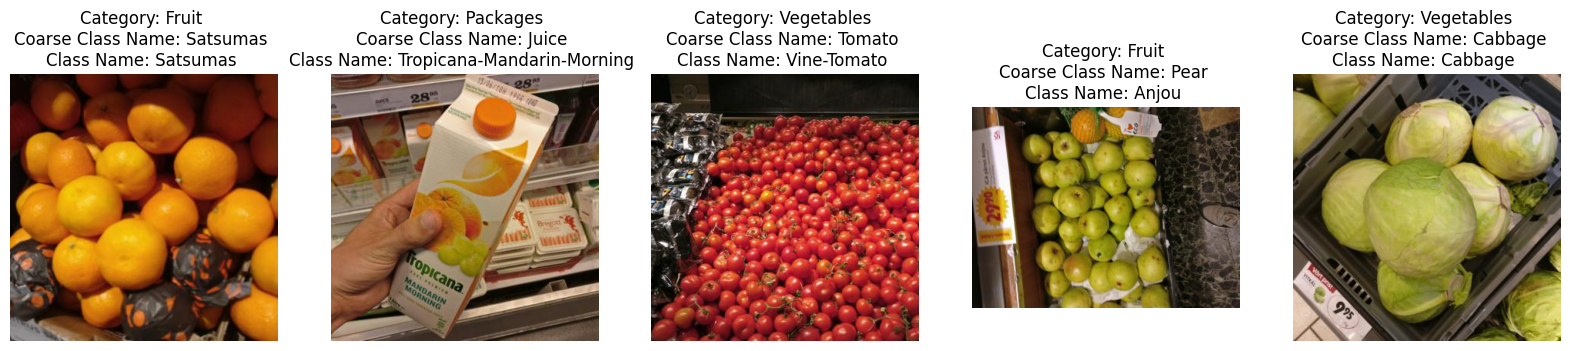

In [59]:
# Llamar a la función para mostrar 5 imágenes aleatorias, con el nombre de la clase
mostrar_imagenes_aleatorias(df_final, n=5)

In [60]:
# Preparar las etiquetas de clase
labels = df_final['class_id'].values

# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(df_final['filename'], labels, test_size=0.2, random_state=seed_value)

# Convertir las etiquetas a una representación one-hot
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Definir el tamaño de la imagen que se usará en el modelo
img_size = (128, 128)

# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(image_path, target_size=img_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalizar los píxeles
    return img_array

# Preprocesar las imágenes de entrenamiento y validación
X_train_images = np.array([load_and_preprocess_image(data_dir+img_path) for img_path in X_train])
X_val_images = np.array([load_and_preprocess_image(data_dir+img_path) for img_path in X_val])

print("Datos de entrenamiento:", X_train_images.shape)
print("Datos de validación:", X_val_images.shape)

Datos de entrenamiento: (4334, 128, 128, 3)
Datos de validación: (1084, 128, 128, 3)


In [61]:
#MODELO
# Definir el modelo CNN
model = models.Sequential([
    layers.InputLayer(input_shape=(128, 128, 3)),  # Tamaño de entrada de las imágenes
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),  # Aplanar las salidas de las capas convolucionales
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='softmax')  # Número de clases
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)     

In [62]:
%%time

# Entrenar el modelo
history = model.fit(X_train_images, y_train, epochs=10, batch_size=32, validation_data=(X_val_images, y_val))

# Evaluar el modelo en el conjunto de validación
test_loss, test_acc = model.evaluate(X_val_images, y_val)
print(f"\nPrecisión en validación: {test_acc:.4f}")
print('')

Epoch 1/10
136/136 [==============================] - 138s 1s/step - loss: 3.7682 - accuracy: 0.0994 - val_loss: 2.8530 - val_accuracy: 0.2352
Epoch 2/10
136/136 [==============================] - 133s 978ms/step - loss: 2.6272 - accuracy: 0.2723 - val_loss: 2.0080 - val_accuracy: 0.4363
Epoch 3/10
136/136 [==============================] - 132s 972ms/step - loss: 1.7714 - accuracy: 0.4652 - val_loss: 1.5368 - val_accuracy: 0.5378
Epoch 4/10
136/136 [==============================] - 135s 995ms/step - loss: 1.3235 - accuracy: 0.5881 - val_loss: 1.3084 - val_accuracy: 0.5793
Epoch 5/10
136/136 [==============================] - 140s 1s/step - loss: 1.0168 - accuracy: 0.6742 - val_loss: 1.1854 - val_accuracy: 0.6319
Epoch 6/10
136/136 [==============================] - 143s 1s/step - loss: 0.7221 - accuracy: 0.7603 - val_loss: 1.2919 - val_accuracy: 0.6061
Epoch 7/10
136/136 [==============================] - 135s 995ms/step - loss: 0.5601 - accuracy: 0.8170 - val_loss: 1.1062 - val_accu

Al reducir el tamaño de la imagen configurada en la red, pasando de 224x224px a 128x128px y manteniendo la misma configuración de epoch, se evidencia una mejora en la precisión de validación.